In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from tqdm import tqdm
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn.functional as F
import copy
import sys

/home/haicore-project-hereon/eu7630/miniconda3/envs/plankton/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from cycler import cycler

hereon_color_array = np.array([
    [230, 0, 70],
    [0, 145, 160],
    [0, 170, 230],
    [250, 180, 35],
    [0, 70, 125],
    [175, 25, 60],
    [170, 200, 70],
    [250, 115, 80],
    [140, 90, 180],

])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)
mpl.rc('image', cmap='gray')
mpl.rcParams['axes.prop_cycle'] = cycler(color=hereon_color_array)
sns.set_palette(hereon_color_array)

In [3]:
train_data_file = "/hkfs/work/workspace/scratch/bh6321-energy_challenge/data/train.csv"
valid_data_file = "/hkfs/work/workspace/scratch/bh6321-energy_challenge/data/valid.csv"
prediction_time_window=168
past_time_window=168

In [4]:
df = pd.read_csv(train_data_file)
df

,Load [MWh],Time [s],City
0,263.365956,2015-01-01 00:00:00,bs
1,259.073621,2015-01-01 01:00:00,bs
2,246.612481,2015-01-01 02:00:00,bs
3,238.313719,2015-01-01 03:00:00,bs
4,237.114390,2015-01-01 04:00:00,bs
...,...,...,...
368251,322.822588,2017-12-31 19:00:00,sz
368252,312.235274,2017-12-31 20:00:00,sz
368253,317.510833,2017-12-31 21:00:00,sz
368254,325.311059,2017-12-31 22:00:00,sz


In [13]:
city_data = []
city_names = pd.unique(df["City"])
for city in tqdm(city_names):
    city_data.append(df[df["City"] == city]["Load [MWh]"].to_numpy())

unique_time = np.expand_dims(pd.to_datetime(df[df["City"] == city]["Time [s]"]).astype(int).to_numpy() / 10**9 / 3600, 1)
city_data = np.moveaxis(np.array(city_data), 0, -1)
train_dataset = city_data

var_data = np.concatenate([unique_time, train_dataset], axis=1)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 66.86it/s]


In [14]:
# fit the model:
model = VAR(var_data)
model_fit = model.fit(maxlags=24*7)



In [15]:
# print(sys.getsizeof(model_fit))
print((model_fit.df_model -1)/ 15)
# fig, ax = plt.subplots(figsize=(10, 10))
# sns.lineplot(data=df, x="Time [s]", y="Load [MWh]", style="City", ax=ax, hue="City")
# plt.tight_layout()
# plt.savefig("all_data.png", dpi=300)

168.0


In [16]:
import torch
from torch.utils.data import Dataset, DataLoader


class CustomLoadDataset(Dataset):
    def __init__(self, data_file, historic_window, forecast_horizon, city_names, device=None, normalize=True):
        # Input sequence length and output (forecast) sequence length
        self.historic_window = historic_window
        self.forecast_horizon = forecast_horizon
        
        df = pd.read_csv(data_file)
        # Load Data from csv to Pandas Dataframe
        city_data = []
        for city in tqdm(city_names):
            city_data.append(df[df["City"] == city]["Load [MWh]"].to_numpy())

        unique_time = np.expand_dims(pd.to_datetime(df[df["City"] == city]["Time [s]"]).astype(int).to_numpy() / 10**9 / 3600, 1)
        city_data = np.moveaxis(np.array(city_data), 0, -1)
        self.dataset = city_data
        self.dataset = np.concatenate([unique_time, self.dataset], axis=1)

    def __len__(self):
        return int(self.dataset.shape[0] - self.historic_window - self.forecast_horizon)

    def __getitem__(self, idx):
        # translate idx (day nr) to array index
        x = self.dataset[idx:idx+self.historic_window, ]
        y = self.dataset[idx+self.historic_window: idx+self.historic_window + self.forecast_horizon, ]

        return x, y


In [17]:
valid_dataset = CustomLoadDataset(data_file=valid_data_file, 
                                  historic_window=past_time_window, 
                                  forecast_horizon=prediction_time_window,
                                  city_names=city_names,
                                  device=None, 
                                  normalize=False)

valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True,
           num_workers=2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 180.09it/s]


In [18]:
errors = []
for x,y in tqdm(valid_dataloader):
    x = x.squeeze(0).cpu().numpy()
    y = y.squeeze(0).cpu().numpy()[:, 1:]
    preds = model_fit.forecast(x, steps=168)[:, 1:]
    
    # preds = valid_dataset.revert_normalization(preds)
    # y = valid_dataset.revert_normalization(y)
    
    all_predictions = preds
    all_val = y
    errors.append(mean_absolute_error(y_true=y, y_pred=preds))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8424/8424 [08:59<00:00, 15.61it/s]


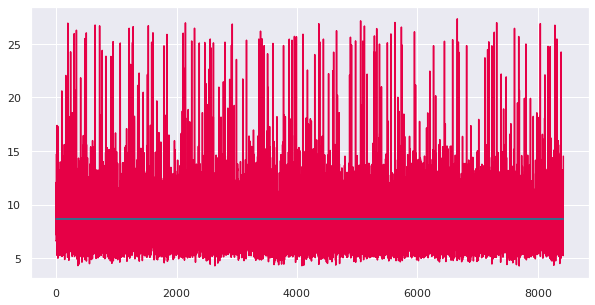

In [19]:
errors = np.array(errors)
mean_error = np.mean(errors)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(errors)
ax.plot(np.arange(len(errors)), [mean_error for _ in range(len(errors))])

In [20]:
mean_error

8.6629624101463

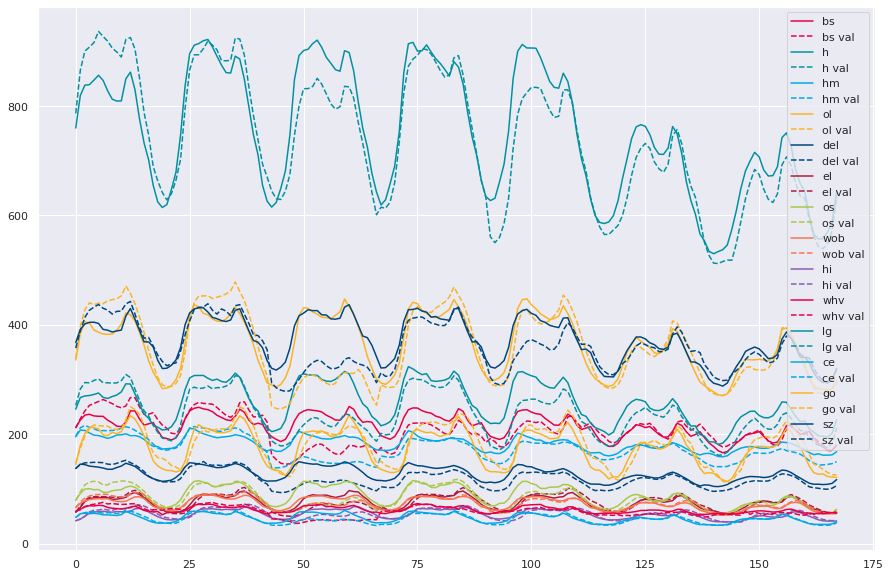

In [23]:
fig, ax1 = plt.subplots(figsize=(15,10), nrows=1)
for i, (this_pred, this_val) in enumerate(zip(np.array(all_predictions).T, np.array(all_val).T)):
    ax1.plot(np.arange(len(this_pred)), this_pred, label=city_names[i], color=hereon_color_array[i%9])
    ax1.plot(np.arange(len(this_pred)), this_val, label=city_names[i] + " val", color=hereon_color_array[i%9], ls="--")
ax1.legend()